# **Bank Marketing Campaign Strategy**

## Context
A Portuguese banking institution conducted a telemarketing campaign to promote its term deposit product. The main goal of this campaign was to identify whether a customer would subscribe to the term deposit after being contacted. Information collected during the campaign includes demographic data, socio-economic status, and interaction details from current and previous campaigns.

**Target:**
- **0**: The customer did not subscribe to the term deposit (`y = "no"`)
- **1**: The customer subscribed to the term deposit (`y = "yes"`)

## Problem Statement
Telemarketing campaigns are expensive and time-consuming, especially if conducted without targeting. The bank aims to build a system that can predict the likelihood of a customer subscribing to the term deposit, so they can focus efforts on the most promising leads.

If a call is made to a customer who is unlikely to subscribe, it wastes time and money. On the other hand, if a potential customer is not contacted, it results in a missed opportunity.

## Goals
Based on the problem above, the goals are:
- Predict whether a customer will subscribe to a term deposit or not.
- Identify the most influential factors/variables that drive a customer to subscribe.

## Analytic Approach
- Analyze historical marketing data to find patterns in customer behavior related to subscription.
- Build a classification model (e.g., Logistic Regression, Decision Tree, Random Forest, etc.) to predict the likelihood of a customer subscribing.

## Metric Evaluation

- **Type 1 Error (False Positive):** Predicting that a customer will subscribe when they actually won’t.  
  **Consequence:** Wasted campaign time and cost.

- **Type 2 Error (False Negative):** Predicting that a customer will not subscribe when they actually would.  
  **Consequence:** Missed opportunity to acquire a customer.

Given the consequences, the goal is to:
- Maximize true positive predictions,
- Minimize false positives without losing too many true positives.

**Primary metric to use**: `roc_auc` and `recall` on the positive class.

---

## Data Understanding

**Dataset source**: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)

### Attribute Information

| Attribute           | Data Type | Category Type | Description |
|---------------------|-----------|----------------|-------------|
| age                 | int64     | Numeric        | Age of the customer |
| job                 | object    | Categorical    | Type of job |
| marital             | object    | Categorical    | Marital status |
| education           | object    | Categorical    | Education level |
| default             | object    | Categorical    | Has credit in default? (yes/no/unknown) |
| housing             | object    | Categorical    | Has a housing loan? |
| loan                | object    | Categorical    | Has a personal loan? |
| contact             | object    | Categorical    | Type of communication contact |
| month               | object    | Categorical    | Last contact month |
| day_of_week         | object    | Categorical    | Last contact day of the week |
| duration            | int64     | Numeric        | Duration of last contact (in seconds) |
| campaign            | int64     | Numeric        | Number of contacts performed during this campaign |
| pdays               | int64     | Numeric        | Days since the client was last contacted (999 means never contacted before) |
| previous            | int64     | Numeric        | Number of contacts performed before this campaign |
| poutcome            | object    | Categorical    | Outcome of the previous campaign |
| emp.var.rate        | float64   | Numeric        | Employment variation rate |
| cons.price.idx      | float64   | Numeric        | Consumer price index |
| cons.conf.idx       | float64   | Numeric        | Consumer confidence index |
| euribor3m           | float64   | Numeric        | Euribor 3 month rate |
| nr.employed         | float64   | Numeric        | Number of people employed |
| y                   | object    | Categorical    | Target: has the client subscribed a term deposit? (yes/no) |

**Notes**:
- The dataset is **imbalanced** (majority class is non-subscription).
- Most features are **categorical** (Nominal, Binary, Ordinal).

---

## Data Preparation

In [272]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler
import category_encoders as ce

# Import machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [273]:
warnings.filterwarnings('ignore')

In [274]:
# Load the dataset
df = pd.read_csv('bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [275]:
df.shape

(41188, 21)

In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [277]:
# Describe the dataset
display(df.describe(), df.describe(include='object'))

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


In [278]:
listItem = []
for col in df.columns :
    listItem.append([   col,
                        df[col].dtype ,
                        # Numeric" if df[col].dtype == 'int64' or df[col].dtype == 'float64' else
                        "Numeric" if df[col].dtype in ['int64', 'float64'] else
                        "Categorical",
                        df[col].isnull().sum(),
                        f"{(df[col].isnull().sum()/df[col].shape[0])*100:.2f}%",
                        df[col].nunique(),
                        df[col].unique()])

tabel_Desc = pd.DataFrame(columns=['Column Name','Data Type','Category Type','Null', 'Percentage Null', 'Number of Unique', 'Unique Sample'],
                    data=listItem)
tabel_Desc

,Column Name,Data Type,Category Type,Null,Percentage Null,Number of Unique,Unique Sample
0,age,int64,Numeric,0,0.00%,78,"[56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 5..."
1,job,object,Categorical,0,0.00%,12,"[housemaid, services, admin., blue-collar, tec..."
2,marital,object,Categorical,0,0.00%,4,"[married, single, divorced, unknown]"
3,education,object,Categorical,0,0.00%,8,"[basic.4y, high.school, basic.6y, basic.9y, pr..."
4,default,object,Categorical,0,0.00%,3,"[no, unknown, yes]"
5,housing,object,Categorical,0,0.00%,3,"[no, yes, unknown]"
6,loan,object,Categorical,0,0.00%,3,"[no, yes, unknown]"
7,contact,object,Categorical,0,0.00%,2,"[telephone, cellular]"
8,month,object,Categorical,0,0.00%,10,"[may, jun, jul, aug, oct, nov, dec, mar, apr, ..."
9,day_of_week,object,Categorical,0,0.00%,5,"[mon, tue, wed, thu, fri]"


In [279]:
# Check all unique values in the categorical columns
def check_unique_values(df):
    for col in df.select_dtypes(include=['object']).columns:
        print(f"Unique values in {col}: {df[col].unique()}")

check_unique_values(df)

Unique values in job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
Unique values in marital: ['married' 'single' 'divorced' 'unknown']
Unique values in education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
Unique values in default: ['no' 'unknown' 'yes']
Unique values in housing: ['no' 'yes' 'unknown']
Unique values in loan: ['no' 'yes' 'unknown']
Unique values in contact: ['telephone' 'cellular']
Unique values in month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
Unique values in day_of_week: ['mon' 'tue' 'wed' 'thu' 'fri']
Unique values in poutcome: ['nonexistent' 'failure' 'success']
Unique values in y: ['no' 'yes']


## Data Cleaning

### Null Values

In [280]:
# Check the null values
print(f"The number of null values in the dataset is:\n{df.isnull().sum()}\n")
print(f"The number of na values in the dataset is:\n{df.isna().sum()}")

The number of null values in the dataset is:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

The number of na values in the dataset is:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


We can see that there is no null value in the dataset.

### Duplicates

In [281]:
# Drop duplicates
df[df.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no


In [282]:
df.duplicated().sum()

np.int64(12)

In [283]:
df.shape

(41188, 21)

In [284]:
df = df.drop_duplicates()
df.shape

(41176, 21)

The duplicate rows have been successfully dropped.

### Unnecessary/Risky Columns

In [285]:
# Drop columns that are dependent on the target to prevent leakage
df.drop(columns=['duration'], inplace=True)

In [286]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'y'],
      dtype='object')

The `duration` column has been successfully dropped.

### Outliers

In [287]:
# List all numeric columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_columns

['age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

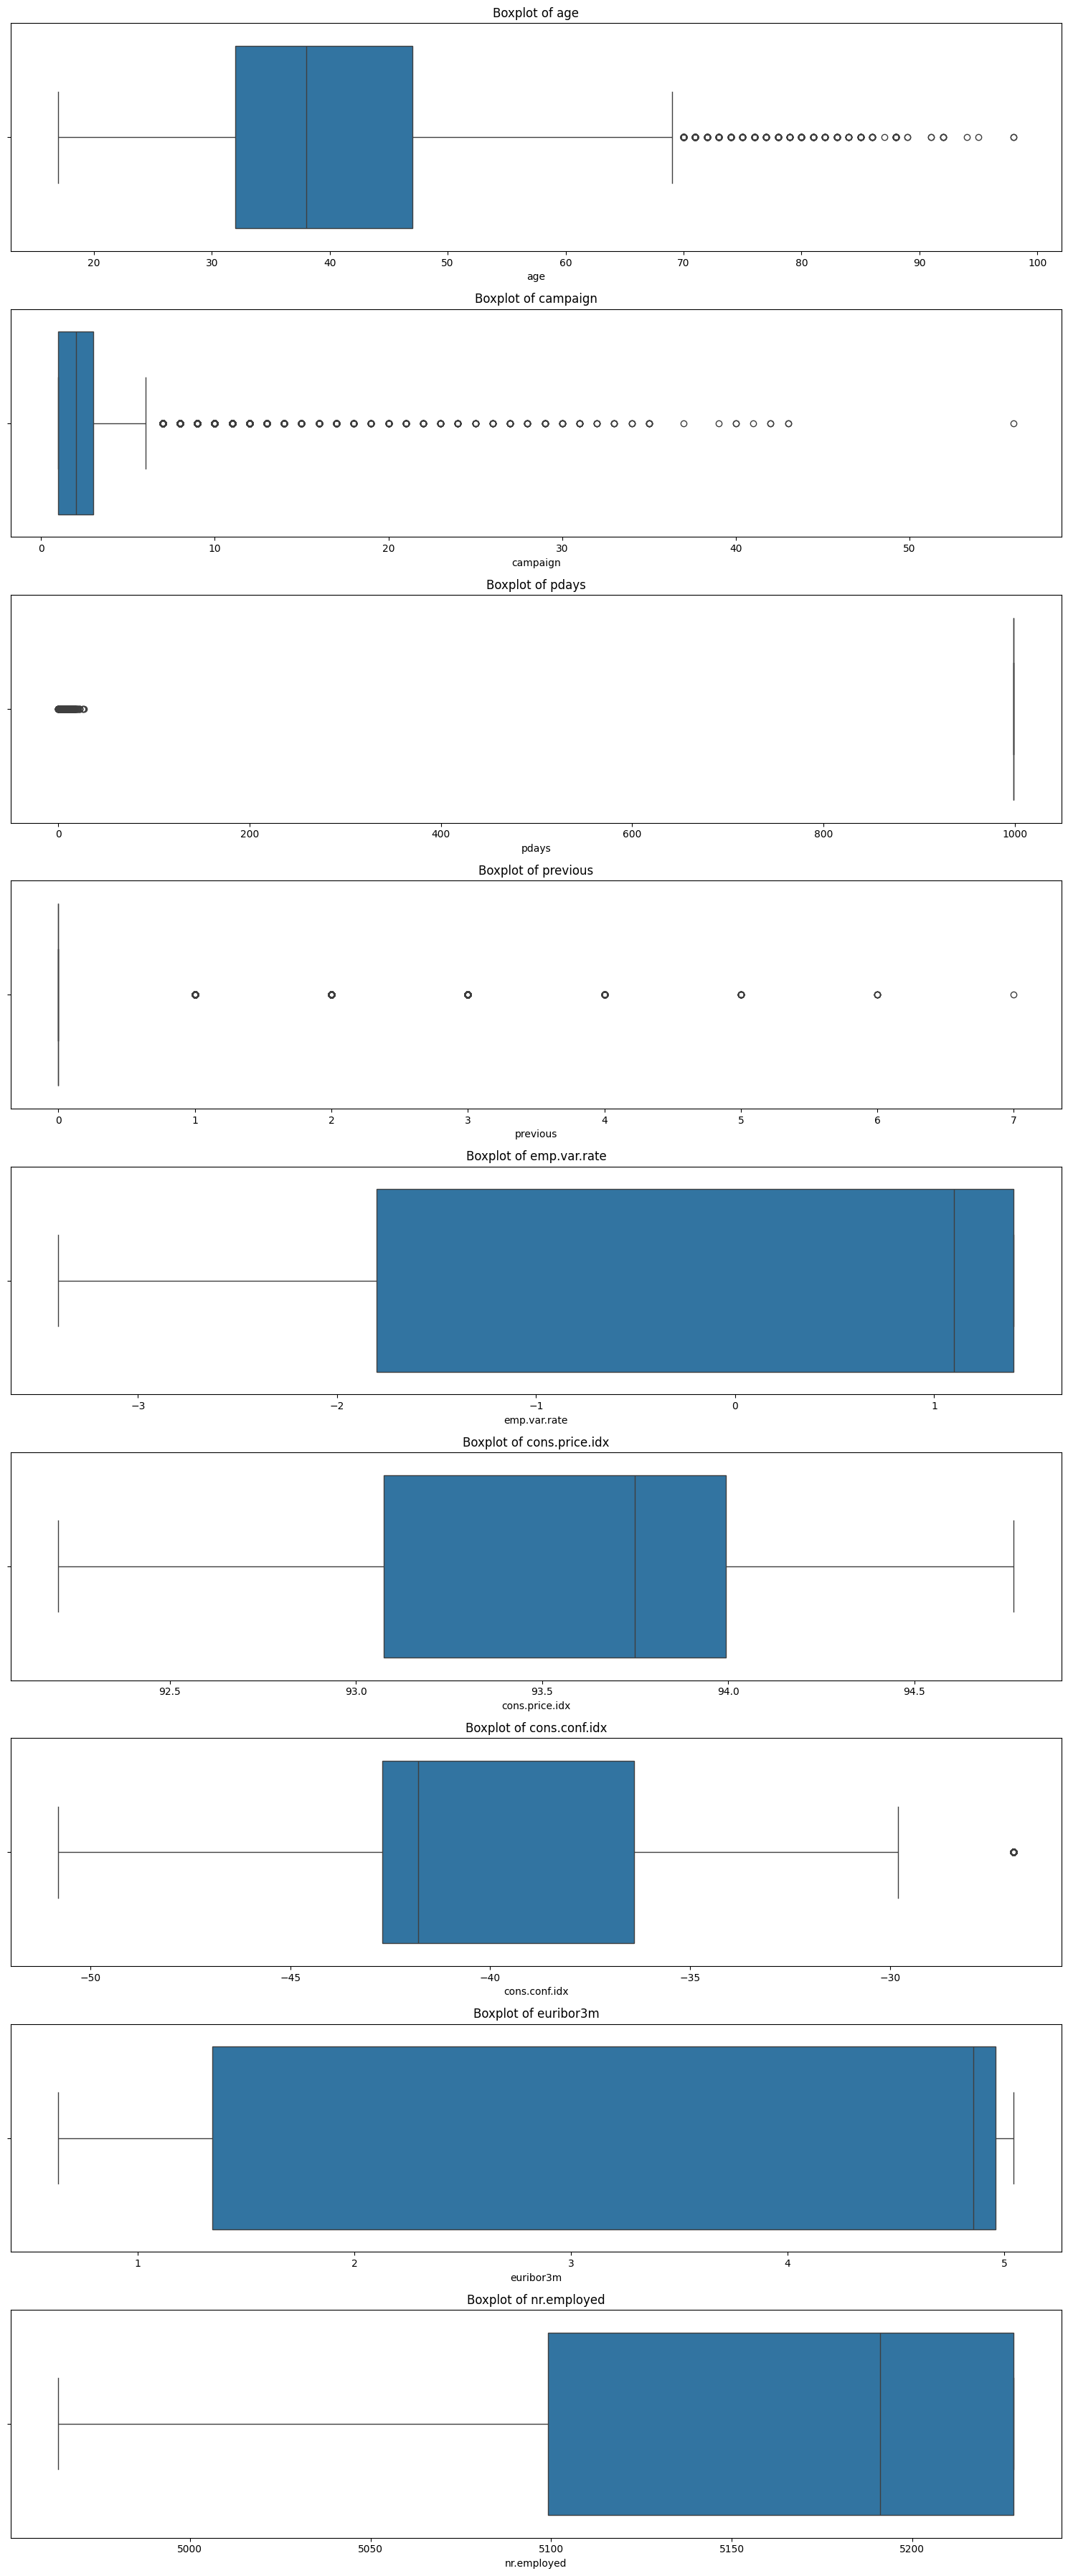

In [288]:
# Set up the figure
plt.figure(figsize=(15, len(numeric_columns) * 4))

# Plot each numeric column as a boxplot
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()


From the boxplot, we can make the following observations:
1. The columns `age`, `campaign`, and `previous` have many outliers due to the variety of values stored.
1. The column `pdays` has the value '999' which does not indicate a number, but has a meaning of 'Never contacted' instead. Most of the data lies here.
1. The column `cons.conf.idx` has outliers that could need handling.
1. Other than that, the other columns seem to have values that fall within the IQR boundaries.

### Handling Outliers

We are going to use the binning technique to handle outliers in the numeric data, changing them to become categorical data.

#### 1. `age`

The binning for age follows United Nations (UN) age classification standard on Earning Activities and the Inactive with Medium detail (https://unstats.un.org/unsd/publication/SeriesM/SeriesM_74e.pdf)

In [289]:
# Perform binning on the 'age' column with equal frequency binning
def binning_age(df, col_name, bins, new_col_name):
    labels = [f"{bins[i]+1}-{bins[i+1]}" for i in range(len(bins)-1)]
    df[new_col_name] = pd.cut(df[col_name], bins=bins, labels=labels, right=True, include_lowest=True)
    return df

# Define the bins for age
bins = [14, 24, 54, 74, 84, 100]
# Apply binning
df = binning_age(df, 'age', bins, 'age_group')
# Check the result
df['age_group'].value_counts().sort_index()

age_group
15-24      1067
25-54     35881
55-74      3959
75-84       211
85-100       58
Name: count, dtype: int64

In [290]:
# Drop the original 'age' column
df.drop(columns=['age'], inplace=True)
df.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'y', 'age_group'],
      dtype='object')

#### 2. `campaign`

We are going to perform binning on the `campaign` column with equal interval. However, the '0' will be grouped on its own because it indicates that the client has not been contacted in this campaign at all.

In [291]:
# Sample data
campaign = df['campaign']
non_zero = campaign[campaign > 0]

# Number of non-zero bins
n_bins = 4

# Create equal-width bins for non-zero values
non_zero_bins = pd.cut(non_zero, bins=n_bins)

# Get bin edges
edges = non_zero_bins.cat.categories

# Manually define bin edges (0 bin separately, then use cut edges)
bin_edges = [0] + [edges[0].left] + [e.right for e in edges]

# Clean: ensure edges are strictly increasing and unique
bin_edges = sorted(set(bin_edges))

# Create bin labels
bin_labels = ['0']  # first bin for value 0
bin_labels += [f"{int(edges[i].left)+1}–{int(edges[i].right)}" for i in range(len(edges))]

# Final binning
df['campaign_group'] = pd.cut(campaign, bins=bin_edges, labels=bin_labels, include_lowest=True)

# Preview
print(df[['campaign', 'campaign_group']].head(10))


   campaign campaign_group
0         1           1–14
1         1           1–14
2         1           1–14
3         1           1–14
4         1           1–14
5         1           1–14
6         1           1–14
7         1           1–14
8         1           1–14
9         1           1–14


In [292]:
df['campaign_group'].value_counts().sort_index()

campaign_group
0            0
1–14     40770
15–28      356
29–42       47
43–56        3
Name: count, dtype: int64

The bins are very imbalanced. Because this column indicates frequency of contact in a campaign, we would change this into custom bins instead using the knowledge that we have gathered.

In [293]:
# Define custom bins and labels
bin_edges = [0, 0.5, 5.5, 10.5, 15.5, 30.5, np.inf]
bin_labels = ['0', '1–5', '6–10', '11–15', '16–30', '31+']

# Apply binning
df['campaign_group'] = pd.cut(df['campaign'], bins=bin_edges, labels=bin_labels, right=True, include_lowest=True)

# Preview result
print(df[['campaign', 'campaign_group']].head(10))

   campaign campaign_group
0         1            1–5
1         1            1–5
2         1            1–5
3         1            1–5
4         1            1–5
5         1            1–5
6         1            1–5
7         1            1–5
8         1            1–5
9         1            1–5


In [294]:
# Check the distribution of the new 'campaign_group' column
df['campaign_group'].value_counts().sort_index()

campaign_group
0            0
1–5      37791
6–10      2516
11–15      514
16–30      322
31+         33
Name: count, dtype: int64

In [295]:
# Drop the original 'campaign' column
df.drop(columns=['campaign'], inplace=True)
df.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'pdays', 'previous', 'poutcome', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'age_group', 'campaign_group'],
      dtype='object')

#### 3. `previous`

In [296]:
# Check the 'previous' column value distribution
df['previous'].value_counts().sort_index()

previous
0    35551
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: count, dtype: int64

We are going to group the numbers 4 and above together.

In [297]:
# Create the 'previous_group' column
df['previous_group'] = df['previous'].apply(lambda x: str(x) if x < 4 else '4+')

# Preview result
print(df[['previous', 'previous_group']].head(10))

   previous previous_group
0         0              0
1         0              0
2         0              0
3         0              0
4         0              0
5         0              0
6         0              0
7         0              0
8         0              0
9         0              0


In [298]:
# Preview result
print(df[['previous_group']].value_counts().sort_index())

previous_group
0                 35551
1                  4561
2                   754
3                   216
4+                   94
Name: count, dtype: int64


In [299]:
# Drop the original 'previous' column
df.drop(columns=['previous'], inplace=True)
df.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'pdays', 'poutcome', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'age_group', 'campaign_group', 'previous_group'],
      dtype='object')

#### 4. `pdays`

In [300]:
# Sample data
pdays = df['pdays']

# Separate 999 values (not contacted)
contacted = pdays[pdays < 999]

# Number of bins for contacted
n_bins = 4

# Create equal-width bins for contacted (pdays < 999)
contacted_bins = pd.cut(contacted, bins=n_bins)

# Get bin edges
edges = contacted_bins.cat.categories

# Use the bin edges from contacted, add 999 as the last right edge
bin_edges = [e.left for e in edges] + [edges[-1].right, 1000]  # Add 1000 to catch 999 as upper bound

# Create bin labels
bin_labels = [f"{int(edges[i].left)}–{int(edges[i].right)}" for i in range(len(edges))]
bin_labels += ['Not contacted']  # Label for 999

# Final binning
df['pdays_group'] = pd.cut(pdays, bins=bin_edges, labels=bin_labels, include_lowest=True, right=True)

# Preview
print(df[['pdays', 'pdays_group']].head(10))

   pdays    pdays_group
0    999  Not contacted
1    999  Not contacted
2    999  Not contacted
3    999  Not contacted
4    999  Not contacted
5    999  Not contacted
6    999  Not contacted
7    999  Not contacted
8    999  Not contacted
9    999  Not contacted


In [301]:
df['pdays_group'].value_counts().sort_index()

pdays_group
0–6               1117
6–13               316
13–20               74
20–27                8
Not contacted    39661
Name: count, dtype: int64

In [302]:
# Drop the original 'pdays' column
df.drop(columns=['pdays'], inplace=True)
df.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'age_group',
       'campaign_group', 'previous_group', 'pdays_group'],
      dtype='object')

### 5. `cons.conf.idx`

In [303]:
Q1 = df['cons.conf.idx'].quantile(0.25)
Q3 = df['cons.conf.idx'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['cons.conf.idx'] < lower_bound) | (df['cons.conf.idx'] > upper_bound)]

# Number of outliers
num_outliers = outliers.shape[0]
print(f"Number of outliers in cons.conf.idx: {num_outliers}")


Number of outliers in cons.conf.idx: 446


In [304]:
print(f"Percentage of outliers in cons.conf.idx: {(num_outliers / df.shape[0]) * 100:.2f}%")

Percentage of outliers in cons.conf.idx: 1.08%


## EDA

In [305]:
# Redefine numeric columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_columns

['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [306]:
X = df.select_dtypes(include=[float, int])  # select numeric features
X = add_constant(X)  # add intercept

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

          Feature            VIF
0           const  521733.605705
1    emp.var.rate      32.897863
2  cons.price.idx       6.294354
3   cons.conf.idx       2.596859
4       euribor3m      63.860354
5     nr.employed      30.743930


In [307]:
# Drop euribor3m column
df.drop(columns=['euribor3m'], inplace=True)

In [308]:
# Recheck VIF
X = df.select_dtypes(include=[float, int])  # select numeric features
X = add_constant(X)  # add intercept

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

          Feature            VIF
0           const  342526.392708
1    emp.var.rate      24.034565
2  cons.price.idx       5.494398
3   cons.conf.idx       1.266532
4     nr.employed      12.512258


In [309]:
# Drop 'emp.var.rate' column
df.drop(columns=['emp.var.rate'], inplace=True)

In [310]:
# Recheck VIF
X = df.select_dtypes(include=[float, int])  # select numeric features
X = add_constant(X)  # add intercept

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

          Feature           VIF
0           const  26658.221622
1  cons.price.idx      1.374515
2   cons.conf.idx      1.010302
3     nr.employed      1.383729


In [311]:
# Redefine numeric columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_columns

['cons.price.idx', 'cons.conf.idx', 'nr.employed']

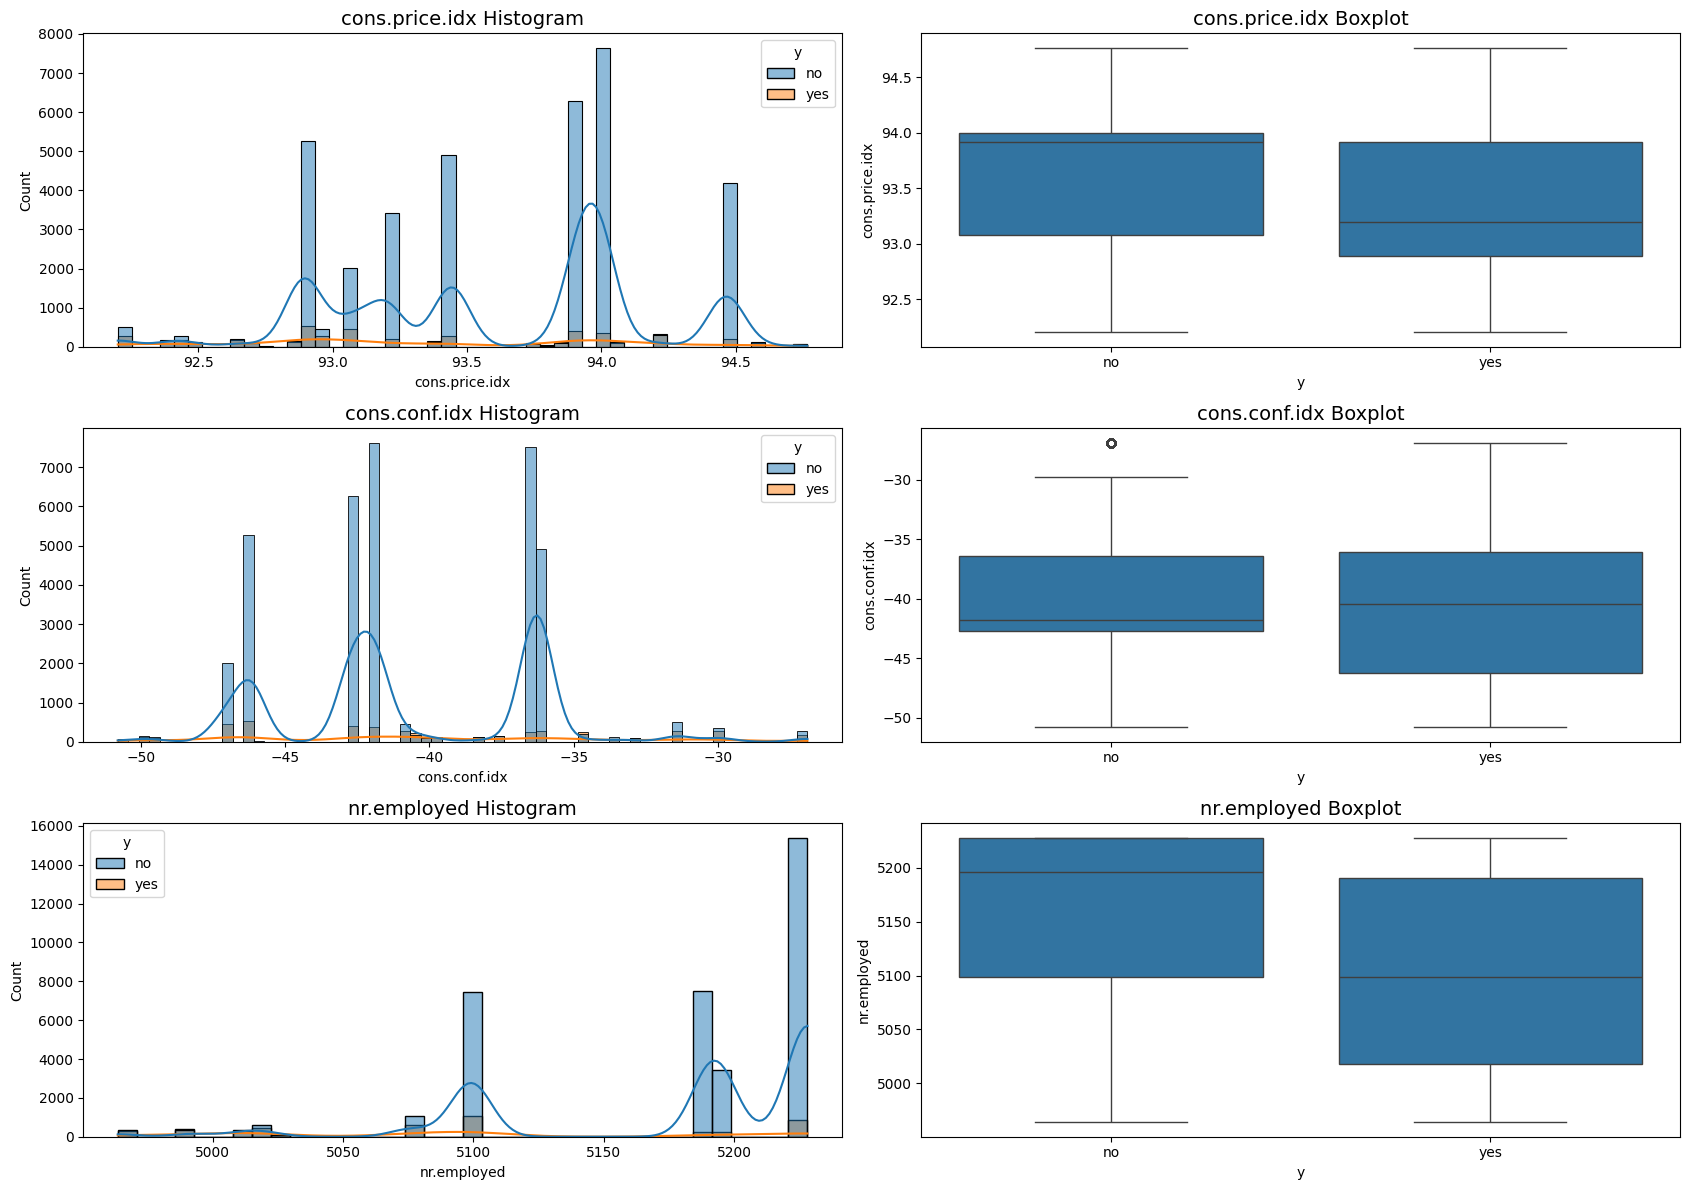

In [312]:
plt.figure(figsize=(17, 12))

def plot_hist(col_name, index, total):
    plt.subplot(total, 2, index * 2 - 1)  # Odd positions for histograms
    sns.histplot(data=df, x=col_name, hue='y', kde=True)
    plt.title(f'{col_name} Histogram', fontsize=14)

def plot_box(col_name, index, total):
    plt.subplot(total, 2, index * 2)  # Even positions for boxplots
    sns.boxplot(data=df, y=col_name, x='y')
    plt.title(f'{col_name} Boxplot', fontsize=14)

total = len(numeric_columns)

for idx, col in enumerate(numeric_columns):
    plot_hist(col, idx + 1, total)

for idx, col in enumerate(numeric_columns):
    plot_box(col, idx + 1, total)

plt.tight_layout()
plt.show()


## Preprocessing

In [313]:
df.columns

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'cons.price.idx', 'cons.conf.idx',
       'nr.employed', 'y', 'age_group', 'campaign_group', 'previous_group',
       'pdays_group'],
      dtype='object')

In [314]:
listItem = []
for col in df.columns :
    listItem.append([   col,
                        df[col].dtype ,
                        # Numeric" if df[col].dtype == 'int64' or df[col].dtype == 'float64' else
                        "Numeric" if df[col].dtype in ['int64', 'float64'] else
                        "Categorical",
                        df[col].isnull().sum(),
                        f"{(df[col].isnull().sum()/df[col].shape[0])*100:.2f}%",
                        df[col].nunique(),
                        df[col].unique()])

tabel_Desc = pd.DataFrame(columns=['Column Name','Data Type','Category Type','Null', 'Percentage Null', 'Number of Unique', 'Unique Sample'],
                    data=listItem)
tabel_Desc

,Column Name,Data Type,Category Type,Null,Percentage Null,Number of Unique,Unique Sample
0,job,object,Categorical,0,0.00%,12,"[housemaid, services, admin., blue-collar, tec..."
1,marital,object,Categorical,0,0.00%,4,"[married, single, divorced, unknown]"
2,education,object,Categorical,0,0.00%,8,"[basic.4y, high.school, basic.6y, basic.9y, pr..."
3,default,object,Categorical,0,0.00%,3,"[no, unknown, yes]"
4,housing,object,Categorical,0,0.00%,3,"[no, yes, unknown]"
5,loan,object,Categorical,0,0.00%,3,"[no, yes, unknown]"
6,contact,object,Categorical,0,0.00%,2,"[telephone, cellular]"
7,month,object,Categorical,0,0.00%,10,"[may, jun, jul, aug, oct, nov, dec, mar, apr, ..."
8,day_of_week,object,Categorical,0,0.00%,5,"[mon, tue, wed, thu, fri]"
9,poutcome,object,Categorical,0,0.00%,3,"[nonexistent, failure, success]"


In [315]:
# Encode the target variable
df['y'] = df['y'].map({'yes': 1, 'no': 0})

Encoding:
- onehot: marital, education, default, housing, loan, contact, day_of_week, poutcome, age_group, campaign_group, previous_group, pdays_group
- binary: job, month

Scaling:
- Robust: cons.price.idx, cons.conf.idx, nr.employed

In [316]:
# # pipeline mode + onehot
# pipe_mode_onehot = Pipeline([
#     ('imp_mode', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder())
# ])

# # pipeline mode + binary
# pipe_mode_binary = Pipeline([
#     ('imp_mode', SimpleImputer(strategy='most_frequent')),
#     ('binary', BinaryEncoder())
# ])

In [317]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['marital', 'education', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'poutcome', 'age_group', 'campaign_group', 'previous_group', 'pdays_group']),
    ('binary', ce.BinaryEncoder(), ['job', 'month']),
    ('scaler', RobustScaler(), ['cons.price.idx', 'cons.conf.idx', 'nr.employed'])
], remainder='passthrough')

## Data Splitting

In [318]:
X = df.drop(columns=['y'])
y = df['y']

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [320]:
transformed = transformer.fit_transform(X_train)

# Manually define the feature names
onehot_features = transformer.named_transformers_['onehot'].get_feature_names_out(['marital', 'education', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'poutcome', 'age_group', 'campaign_group', 'previous_group', 'pdays_group'])

# BinaryEncoder does not have get_feature_names_out(), but you can get them this way:
binary_encoder = transformer.named_transformers_['binary']
binary_encoded = binary_encoder.transform(X_train[['job', 'month']])
binary_features = binary_encoded.columns.tolist()

scaler_features = ['cons.price.idx', 'cons.conf.idx', 'nr.employed']

# If you are using `remainder='passthrough'`, you'll need to also include those columns
# Get the column names passed through
passthrough_cols = [col for col in X_train.columns if col not in ['marital', 'education', 'default', 'housing', 'loan', 'contact', 'day_of_week', 'poutcome', 'age_group', 'campaign_group', 'previous_group', 'pdays_group', 'job', 'month', 'cons.price.idx', 'cons.conf.idx', 'nr.employed']]

all_features = list(onehot_features) + binary_features + scaler_features + passthrough_cols

testing = pd.DataFrame(transformed, columns=all_features)
testing.head()

,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,...,job_1,job_2,job_3,month_0,month_1,month_2,month_3,cons.price.idx,cons.conf.idx,nr.employed
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.733406,-0.841270,-0.712403
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.183896,-0.142857,0.287597
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.507073,0.238095,-1.545736
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.779108,0.000000,0.287597
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.183896,-0.142857,0.287597


## Modeling & Evaluation

In [321]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()

### 1. Model benchmarking: K-Fold

In [322]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

[LightGBM] [Info] Number of positive: 2969, number of negative: 23383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 149
[LightGBM] [Info] Number of data points in the train set: 26352, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112667 -> initscore=-2.063784
[LightGBM] [Info] Start training from score -2.063784
[LightGBM] [Info] Number of positive: 2969, number of negative: 23383
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 151
[LightGBM] [Info] Number of data points in the train set: 26352, number of used features: 47
[LightGBM] [Info] [bin

,mean roc_auc,sdev
model,,
LightGBM,0.793817,0.006952
Logistic Regression,0.785070,0.006106
XGBoost,0.780692,0.006605
Random Forest,0.749636,0.009858
KNN,0.728167,0.008832
Decision Tree,0.624501,0.004917


LightGBM has the best ROC AUC score.

### 2. Model benchmarking: Test data

In [323]:
models = [logreg,knn,dt,rf,xgb,lgbm]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    X_train,X_test
    
    estimator.fit(X_train,y_train)
    return(estimator,estimator.predict(X_test),X_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM']):
    estimator,y_pred,X_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(X_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.91      0.98      0.95      7308
           1       0.65      0.22      0.33       928

    accuracy                           0.90      8236
   macro avg       0.78      0.60      0.64      8236
weighted avg       0.88      0.90      0.88      8236

KNN 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      7308
           1       0.51      0.26      0.35       928

    accuracy                           0.89      8236
   macro avg       0.71      0.62      0.64      8236
weighted avg       0.87      0.89      0.87      8236

Decision Tree 
               precision    recall  f1-score   support

           0       0.91      0.94      0.93      7308
           1       0.39      0.29      0.33       928

    accuracy                           0.87      8236
   macro avg       0.65      0.62      0.63      8236
weighted avg       0.85      0

,roc_auc score
model,
LightGBM,0.790062
Logistic Regression,0.783777
XGBoost,0.778478
Random Forest,0.745560
KNN,0.716298
Decision Tree,0.614060


Again, LightGBM produced the best results.

### 3. Oversampling test with K-Fold Cross Validation

In [324]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [325]:
from sklearn.model_selection import StratifiedKFold

K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

In [326]:
data = X_train
target = y_train

In [327]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]
    
#     print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler()

    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)

    # instantiate model
    lgbm = lgb.LGBMClassifier()
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',lgbm)
    ])

    #calculate errors
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)
    
    # append to appropriate list
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    
    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

[LightGBM] [Info] Number of positive: 3340, number of negative: 26306
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 151
[LightGBM] [Info] Number of data points in the train set: 29646, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.112663 -> initscore=-2.063826
[LightGBM] [Info] Start training from score -2.063826
[LightGBM] [Info] Number of positive: 26306, number of negative: 26306
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 52612, number of used features: 49
[LightGBM] [Info] [bi

### 4a. Evaluation Metrics Without Oversampling

In [328]:
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.912771,0.897389,0.854701,0.781940,0.705103,0.636905,0.326647,0.223720,0.764006,0.624060
1,0.911455,0.900425,0.856557,0.806475,0.697702,0.665794,0.313174,0.277628,0.759622,0.631902
2,0.912029,0.899211,0.857894,0.791902,0.699834,0.665146,0.316168,0.280323,0.765217,0.615385
3,0.911826,0.900121,0.851743,0.805439,0.697974,0.661886,0.312275,0.269542,0.766912,0.632911
4,0.910949,0.899818,0.859249,0.797955,0.694732,0.667163,0.307784,0.283019,0.758112,0.621302
5,0.911826,0.897086,0.858325,0.775317,0.699724,0.642963,0.316766,0.237197,0.761151,0.611111
6,0.911287,0.904372,0.858556,0.809856,0.695057,0.665863,0.307186,0.264151,0.764531,0.700000
7,0.911658,0.896478,0.861643,0.778002,0.700018,0.628950,0.318263,0.210243,0.756584,0.619048
8,0.910275,0.908318,0.856660,0.810735,0.692539,0.686931,0.305090,0.299191,0.750368,0.725490
9,0.912231,0.896782,0.860570,0.777028,0.701449,0.641273,0.319557,0.233871,0.763780,0.612676


### 4b. Evaluation Metrics With Oversampling

In [329]:
listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.776515,0.843352,0.870582,0.766300,0.774000,0.679283,0.671026,0.568733,0.850453,0.372134
1,0.772428,0.845173,0.866279,0.801376,0.769840,0.693291,0.666388,0.628032,0.845757,0.385124
2,0.774500,0.836369,0.870270,0.790328,0.771935,0.680432,0.668441,0.611860,0.848403,0.364952
3,0.768798,0.839101,0.862014,0.810963,0.766170,0.690617,0.662777,0.649596,0.841133,0.375975
4,0.776990,0.844566,0.868204,0.795676,0.774312,0.688385,0.668061,0.606469,0.854143,0.380711
5,0.777351,0.851245,0.871362,0.769385,0.774697,0.692150,0.668821,0.587601,0.854244,0.392793
6,0.773740,0.861870,0.866646,0.809908,0.770824,0.714912,0.660952,0.638814,0.853475,0.424731
7,0.776344,0.830905,0.866684,0.775705,0.774166,0.670850,0.678134,0.592992,0.843890,0.351438
8,0.772162,0.853370,0.864758,0.811867,0.769440,0.703215,0.663499,0.630728,0.847734,0.403448
9,0.775174,0.834851,0.868169,0.770469,0.772826,0.679850,0.673509,0.615591,0.845405,0.363492


### 5a. Classification Report Without Oversampling

In [330]:
for rep in validation_errors_without_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      2923
           1       0.62      0.22      0.33       371

    accuracy                           0.90      3294
   macro avg       0.77      0.60      0.64      3294
weighted avg       0.88      0.90      0.88      3294

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      2923
           1       0.63      0.28      0.39       371

    accuracy                           0.90      3294
   macro avg       0.77      0.63      0.67      3294
weighted avg       0.88      0.90      0.88      3294

              precision    recall  f1-score   support

           0       0.91      0.98      0.95      2923
           1       0.62      0.28      0.39       371

    accuracy                           0.90      3294
   macro avg       0.76      0.63      0.67      3294
weighted avg       0.88      0.90      0.88      3294

              preci

### 5b. Classification Report With Oversampling

In [331]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      2923
           1       0.37      0.57      0.45       371

    accuracy                           0.84      3294
   macro avg       0.66      0.72      0.68      3294
weighted avg       0.88      0.84      0.86      3294

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      2923
           1       0.39      0.63      0.48       371

    accuracy                           0.85      3294
   macro avg       0.67      0.75      0.69      3294
weighted avg       0.89      0.85      0.86      3294

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      2923
           1       0.36      0.61      0.46       371

    accuracy                           0.84      3294
   macro avg       0.66      0.74      0.68      3294
weighted avg       0.88      0.84      0.85      3294

              preci

### 6. Hyperparameter Tuning

In [332]:
lgbm = lgb.LGBMClassifier()
ros = RandomOverSampler(random_state=42)

estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',lgbm)
])

In [333]:
hyperparam_space=[{
    'model__max_bin': [255, 275, 300, 230],
    'model__num_leaves':[31, 21, 41, 51],
    'model__min_data_in_leaf': [20, 15, 30, 40],
    'model__num_iterations':[100,75, 125, 150],
    'model__learning_rate': [0.1, 0.075, 0.125, 0.05],
    'model__random_state': [42]
}]

In [334]:
grid = GridSearchCV(estimator, n_jobs=-1, param_grid=hyperparam_space, scoring='roc_auc', cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))

In [335]:
grid.fit(X_train,Y_train)
print(grid.best_score_)
print(grid.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 26307, number of negative: 26307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 52614, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0.8001180206090442
{'model__learning_rate': 0.05, 'model__max_bin': 255, 'model__min_data_in_leaf': 20, 'model__num_iterations': 75, 'model__num_leaves': 31, 'model__random_state': 42}


In [336]:
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)

IndexError: indices are out-of-bounds

In [ ]:
estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',lgbm)
])
estimator.fit(X_train, y_train)

IndexError: indices are out-of-bounds

In [ ]:
best_model = grid.best_estimator_

y_pred_default = estimator.predict(X_test)
y_pred_proba_default = estimator.predict_proba(X_test)
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default LGBM : ', roc_auc_default)
print('ROC AUC Score Tuned LGBM : ', roc_auc_tuned)

NotFittedError: Pipeline is not fitted yet.

In [ ]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default LGBM : \n', report_default)
print('Classification Report Tuned LGBM : \n', report_tuned)

## Feature Importances

In [ ]:
coef1 = pd.Series(best_model['model'].feature_importances_, transformer.get_feature_names()).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

## Conclusion & Recommendation

In [ ]:
print('Classification Report Tuned LGBM : \n', report_tuned) 